# Introduction
The purpose of this research is to analyze what influence do different factors have on global life expectancy at birth. This research will investigate the following questions. 

1. Has global life expectancy at birth changed between 2013 to 2018? Which continents and countries have experienced the least and greatest changes?

2. Are a countries' health expenditures and carbon dioxide emissions from consumption of energy associated with life expectancy at birth?

3. Are a countries' military expenditures and birth rate associated with life expectancy at birth?

In this research, we will look at the following factors and variables of each country: 

- Life expectancy at birth (years)
- Health expenditures (% of GDP)
- Carbon dioxide emissions from consumption of energy (MT)
- Population
- Military expenditures (% of GDP)
- Birth rate (Births per 1000 population)

All the data is obtained from CIA World Factbook country comparisons (https://www.cia.gov/library/publications/download).

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests, zipfile, io
import seaborn as sns
import numpy as np
import scipy as sp
import math
from IPython.display import display, Latex

In [2]:
# find info about continents
webpage = 'https://www.cia.gov/library/'\
+'publications/resources/the-world-factbook/geos/xx.html'
page = urlopen(webpage)
soup = BeautifulSoup(page, 'html.parser')
text = [p.text for p in soup.select('#field-geographic-overview')[0].\
        find_all('p')[7:]]
text[0] = text[0][text[0].index(':') + 2:]

# clean the findings and put into a reference dataFrame
continent_list = []
country_list = []
for t in text:
    continent = t[:t.index(' (')]
    countries = t[t.index('): ') + 3: ].replace('*','').split(', ')
    for country in countries:
        if '(' in country:
            country = country[:country.index('(')-1]
        if ';' in country:
            country = country[: -1]
        continent_list.append(continent)
        country_list.append(country)
continent_df = pd.DataFrame({'continent': continent_list, 
                             'country': country_list})

In [3]:
# get all raw data of variables
#   where to find info
need_info = ['life expectancy', 
             'carbon dioxide emission', 'population',
             'health expenditures', 
             'military expenditures', 'birth rate']
file_13 = ['rawdata_2102.txt', 
           'rawdata_2254.txt', 'rawdata_2119.txt', 
           'rawdata_2225.txt', 
           'rawdata_2034.txt', 'rawdata_2054.txt']
file_18 = ['355rank.html', 
           '274rank.html', '335rank.html', 
           '358rank.html', 
           '330rank.html', '345rank.html']
root_13 = 'factbook/rankorder/'
root_18 = 'https://www.cia.gov/library/publications/'\
+'resources/the-world-factbook/fields/'

#    obtain the zipfile for 2013 data
url = 'https://www.cia.gov/library/publications/download/download-2013/factbook.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

#    put into raw dataFrame
dfs_raw_13, dfs_raw_18 = {}, {}
for i in range(len(need_info)):
    dfs_raw_13[need_info[i]] = pd.read_csv(z.open(root_13 + file_13[i]), 
                                             header=None, sep='\t')
    dfs_raw_18[need_info[i]] = pd.read_html(root_18 + file_18[i], header=0)[0]

In [4]:
def clean(row):
    name = str(row[0])
    data = str(row[1])
    if ',' in name:
        name = name[name.index(',')+2:] +' '+ name[:name.index(',')]
    row[0] = name
    if data.rfind(" ") != -1:
        data = data[data.rfind(" ") + 1:]
        data = data.replace(',', '')
        row[1] = float(data)
    return row

dfs_clean_13, dfs_clean_18 = {}, {}

# clean raw data
for item in need_info:
    dfs_clean_13[item] = dfs_raw_13[item].iloc[:, 1:]
    dfs_clean_13[item].columns = ['country', item]
    dfs_clean_13[item] = dfs_clean_13[item].apply(clean, axis=1)
    dfs_clean_18[item] = dfs_raw_18[item].iloc[:, 1:3]
    dfs_clean_18[item].columns = ['country', item]
    dfs_clean_18[item] = dfs_clean_18[item].apply(clean, axis=1)
    dfs_clean_18[item].at[dfs_clean_18[item].\
                          index[dfs_clean_18[item]['country']=='Czechia'][0], 'country'] = 'Czech Republic'

# merge info two big dataframes, each contain data for the year
df_13 = continent_df
df_18 = continent_df
for item in need_info:
    df_13 = df_13.merge(dfs_clean_13[item], how='outer', 
                        left_on='country', right_on='country')
    df_18 = df_18.merge(dfs_clean_18[item], how='outer', 
                        left_on='country', right_on='country')

# Question 1

## 1.1 Has global life expectancy at birth changed between 2013 to 2018?

### Investigation
First, I examine the summary statistics of the two data sets.

In [5]:
display(df_13['life expectancy'].describe())

count    228.000000
mean      71.581579
std        8.893017
min       49.070000
25%       66.717500
50%       74.155000
75%       78.075000
max       89.630000
Name: life expectancy, dtype: float64

In [6]:
display(df_18['life expectancy'].describe())

count    228.000000
mean      73.301754
std        7.561915
min       52.100000
25%       68.550000
50%       75.150000
75%       78.900000
max       89.400000
Name: life expectancy, dtype: float64

Looking at the summaries, there is a minor increase (1.73 years) in mean from 2013 to 2018. Also, although the maximum does not change much, the minimum increased from $49.07$ to $52.10$.

I use box plot and histogram to visualize how the distribution of life expectancy for 2013 and 2018. 

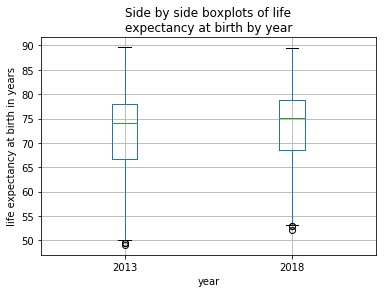

In [7]:
summary_df = pd.DataFrame()
summary_df[2013] = df_13['life expectancy']
summary_df[2018] = df_18['life expectancy']

fig = summary_df.boxplot()
fig.set_xlabel('year')
fig.set_ylabel('life expectancy at birth in years')
fig.set_title('Side by side boxplots of life\nexpectancy at birth by year');

Generally, we see that data points of 2018 is greater than data points of 2013, especially for countries in the lower quartile. 

I further look the histogram, the overall distribution does not change much, while there are fewer countries with life expectancy in the range of 45-60 years. 

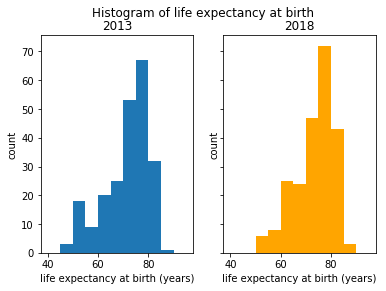

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(df_13['life expectancy'], bins=range(40, 100, 5))
axs[0].set_title('2013')
axs[0].set_ylabel('count')
axs[0].set_xlabel('life expectancy at birth (years)')
axs[1].hist(df_18['life expectancy'], bins=range(40, 100, 5), color='orange')
axs[1].set_title('2018')
axs[1].set_ylabel('count')
axs[1].set_xlabel('life expectancy at birth (years)')
fig.suptitle('Histogram of life expectancy at birth');

The plots have evidence that the there is some change in the distribution of life expectancy at birth, especially for data points in the first quartile. From the histogram, the number of countries with life expectancy at birth between 45-60 decreases. 

### Conclusion
From the observations, we can conclude that there is a change in global life expectancy at birth. From the side by side box plots, the change has more effect on countries with lower life expectancy, and has little effect on countries with high life expectancy. 

### Discussion

The methods used above also has limited considerations for the correlation between life expectancy and the country. For further analysis, I'd like to investigate how much change each country  experienced in life expectancy over the 5 years, and measure the sum of such changes as a measurement of the changes of global life expectancy at birth. 

## 1.2 Which continents have experienced the least and greatest changes?

### Investigation
To examine the changes of life expectancy at birth among continents, I investigate the change of means, maximum, minimum, and median I put them into numerical summaries and side by side box plots for easier visualization. 

<br>

In [9]:
continents = pd.Series(continent_list).unique()

summary_df = pd.DataFrame()
# create a summary for difference in various statistical measures
for continent in continents:
    continent_13 = df_13['life expectancy'].\
        loc[df_13['continent'] == continent].dropna().describe()
    continent_18 = df_18['life expectancy'].\
        loc[df_18['continent'] == continent].dropna().describe()
    diff = continent_18 - continent_13
    diff['continent'] = continent
    diff = diff[['continent','mean','min','max','25%','50%','75%']]
    diff.index = ['continent','diff in mean', 'diff in min', 
                  'diff in max', 'diff in Q1', 'diff in median', 'diff in Q3']
    summary_df = summary_df.append(diff, ignore_index=True)
display(Latex(summary_df.to_latex(index=False)))

<IPython.core.display.Latex object>


Notice that Africa has the greatest changes in mean, and North America has the least changes in mean. 

For a better visualization, we can see them in side by side box plots.

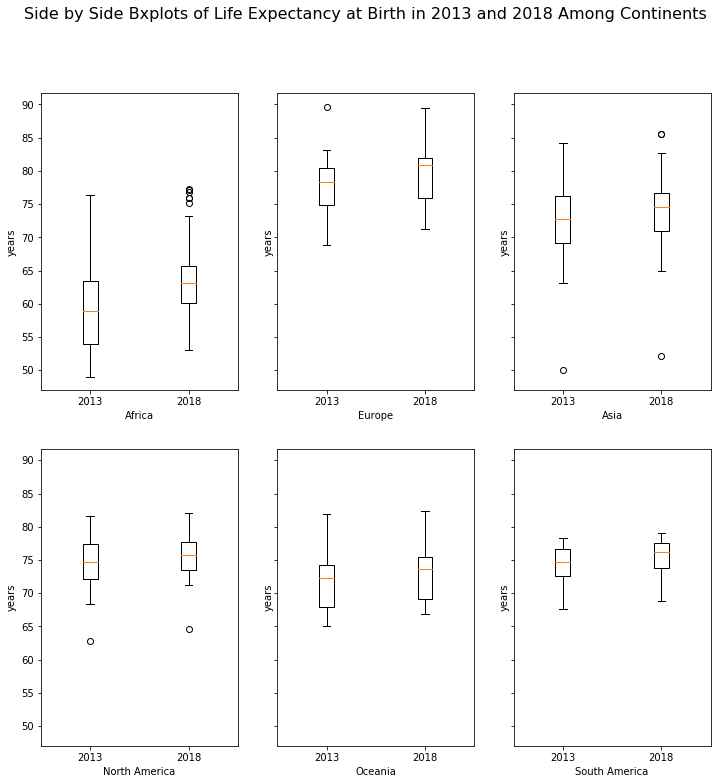

In [10]:
# side by side boxplots
fig, axs = plt.subplots(2, 3, figsize=(12, 12), sharey=True)
fig.suptitle('Side by Side Bxplots of Life Expectancy at Birth in 2013 and 2018 Among Continents',size=16)
for i in range(6):
    continent_13 = df_13['life expectancy'].loc[df_13['continent'] == continents[i]].dropna()
    continent_18 = df_18['life expectancy'].loc[df_18['continent'] == continents[i]].dropna()
    axs[i//3][i%3].boxplot([continent_13, continent_18])
    axs[i//3][i%3].set_xticklabels(['2013','2018'])
    axs[i//3][i%3].set_xlabel(continents[i])
    axs[i//3][i%3].set_ylabel('years');

From the box plots above, we can observe that 
 - Africa has the greatest changes in minimum and median among all continents. 
 - North America has the least changes in median. South America has the least changes in minimum. Oceania has the least change in maximum. However, the difference of the changes in maximum is not significant between Oceania and North America. 
 

### Conclusion
From the observations, there is enough evidence suggesting that Africa experienced the greatest changes, and North America experienced the least changes. 

### Discussion
From the box plots above, I also observe that North America and Oceania both experienced little changes in life expectancy at birth. However, I notice that the number of countries that belong to North America or Oceania are significantly smaller than that of other continents. Since life expectancy at birth is closely associated with the country, this may results in less change in different statistical measurements we've done. 

## 1.3 Which countries have experienced the least and greatest changes?

### Methods
For the changes of each country, we can simply compare the difference of Life Expectancy at birth between 2013 and 2018.<br>



In [11]:
# calculate the change of life expectancy over the 5 years
le_country_df = df_13[['country', 'life expectancy']].\
    merge(df_18[['country', 'life expectancy']], left_on='country', right_on='country')
le_country_df = le_country_df.apply(lambda row: 
    [row['country'], abs(row['life expectancy_y'] - row['life expectancy_x'])], 
                                    axis=1, result_type='expand')
le_country_df.columns = ['country','change in years']
le_country_df = le_country_df.sort_values('change in years').dropna()

In [12]:
display(Latex(le_country_df.head(10).to_latex(index=False)))

<IPython.core.display.Latex object>

In [13]:
display(Latex(le_country_df.tail(10).to_latex(index=False)))

<IPython.core.display.Latex object>

I display the 10 countries with the least changes and 10 countries with the greatest changes. I choose to display 10 countries for more information about the difference of change. Notice that the difference of change in years is much smaller for countries with less changes in life expectancy. 

### Conclusion
From the output above, we observe that Gaza Strip has the least change, while Egypt, West Bank, and Syria also has very little change in life expectancy at birth. Gabon has the most change in life expectancy

### Discussion
Notice that there are many countries with a small change in life expectancy at birth. However, their population may differ a lot. Simply report the change in life expectancy by the difference may not be informative enough. For example, consider Egypt (the second smallest change in life expectancy) and Gaza Strip (the smallest change in life expectancy)

In [14]:
print('population of Egypt: ',
      df_13.loc[df_13['country']=='Egypt']['population'].values[0], 
      '\n\npopulation of Gaza Strip: ',
      df_13.loc[df_13['country']=='Gaza Strip']['population'].values[0])

population of Egypt:  85294388.0 

population of Gaza Strip:  1763387.0


# Question 2

## 2.1 Is a countries' health expenditures associated with life expectancy at birth?

### Investigation
First, we will do a scatter plot of the two variables to visually examine the data.

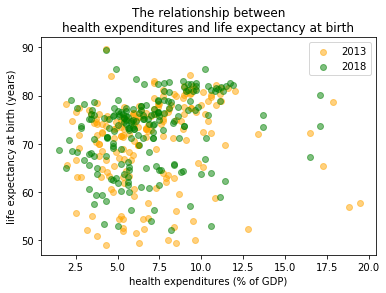

In [16]:
df_m_13 = df_13[['country', 'health expenditures', 'life expectancy']].dropna()
df_m_13['year'] = 2013
df_m_18 = df_18[['country', 'health expenditures', 'life expectancy']].dropna()
df_m_18['year'] = 2018
df_he = df_m_13.append(df_m_18)

# scatter plot and linear regression lines separately
plt.scatter(x=df_he['health expenditures'].loc[df_he['year']==2013], 
            y=df_he['life expectancy'].loc[df_he['year']==2013], 
            color='orange', alpha=0.5)
plt.scatter(x=df_he['health expenditures'].loc[df_he['year']==2018], 
            y=df_he['life expectancy'].loc[df_he['year']==2018], 
            color='green', alpha=0.5)
plt.title('The relationship between\nhealth expenditures and ' + \
          'life expectancy at birth')
plt.xlabel('health expenditures (% of GDP)')
plt.ylabel('life expectancy at birth (years)')
plt.legend(labels=[2013,2018]);

In [18]:
df_m_18.dropna().count()

country                194
health expenditures    194
life expectancy        194
year                   194
dtype: int64

Notice that most countries have life expenditures between $5\%-12.5\%$, and have life expectancy at birth in between $70-85$ years. Also, as health expenditures increase, life expectancy at birth generally increases. The plot shows some evidence that there is a positive linear relationship between health expenditures and life expectancy at birth. 

For further investigation, we encode the health expenditure into a interval variable. Because I expect that the relationship between life expectancy and health expenditures is linear, I group the data points by health expenditures into $4$ even intervals: $0\%-5\%, 5\%-10\%, 10\%-15\%, 15\%-20\%$. 

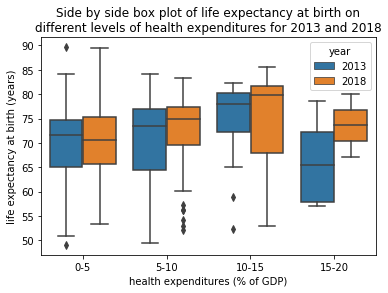

In [224]:
df_he['level'] = np.floor(df_he['health expenditures'] / 5).astype(int)

ax = sns.boxplot(x='level', y='life expectancy', hue='year', data=df_he)
ax.set_xticklabels(['0-5', '5-10','10-15','15-20'])
ax.set_xlabel('health expenditures (% of GDP)')
ax.set_ylabel('life expectancy at birth (years)')
ax.set_title('Side by side box plot of life expectancy at birth on' \
                 + '\ndifferent levels of health expenditures for 2013 and 2018');

The mean difference of countries in $15\%-20\%$ interval between 2013 and 2018 is significantly larger than the rest intervals. Also, the mean is significantly smaller than those of 10-15%. This result is unexpected. I examine these countries closely.

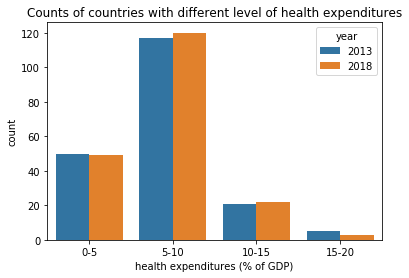

In [225]:
ax = sns.countplot(x='level', hue='year', data=df_he)
ax.set_xticklabels(['0-5', '5-10','10-15','15-20'])
ax.set_xlabel('health expenditures (% of GDP)')
ax.set_title('Counts of countries with different level of health expenditures');

In [226]:
display(Latex(df_he.loc[df_he['level'] == 3].to_latex(index=False)))

<IPython.core.display.Latex object>

Notice that the number of counties that has $15\%-20\%$ health expenditures are significantly smaller than the other 3 levels.s. Also, since the sample size is too small, the box plot for 15-20% health expenditures are not very informative.

For the rest of countries (with health expenditures < 15%), the boxplot shows a constant increase of mean health expectancy when health expenditure increases. I will do an One-way ANOVA to further test whether the mean changes. 

In [227]:
df_he_13 = df_he.loc[df_he['year'] == 2013]
df_he_18 = df_he.loc[df_he['year'] == 2018]

**One-way Analysis of variance (ANOVA)**

Model: $Y_i=\beta_0 + \beta_1 X_{i,1} + \beta_2 X_{i,2} + \epsilon$ 
where 

- $Y_i$ is the life expectancy at birth of the $i$th country, 
- $X_{i,1}$ is the indicator that the $i$th country has health expenditures in between $5-10\%$, 
- $X_{i,2}$ is the indicator that the $i$th country has health expenditures in between $10-15\%$

Assumptions: the error term follows that $e_i\sim N(0, \sigma^2)$

Null hypothesis: $H_0: \beta_1 = \beta_2 = 0, H_a: \beta_1 \neq 0\lor \beta_2\neq 0$ 

Test statistics: $F= \frac{MSReg}{MSE} = \frac{\sum_i (\hat{Y}_i - \bar{Y})^2 / 2}{\sum_i (Y_i-\hat{Y}_i)^2 / 452}\sim F_{2, 452}$

Result of one-way ANOVA on 2013 data

In [228]:
stat, p = sp.stats.f_oneway(df_he_13.loc[df_he_13['level'] == 0]['life expectancy'], 
                  df_he_13.loc[df_he_13['level'] == 1]['life expectancy'], 
                  df_he_13.loc[df_he_13['level'] == 2]['life expectancy'])
print('Test statistics: ', stat, 
      '\np-value:', p)

Test statistics:  2.9511006293486997 
p-value: 0.054748632934573105


Result of one-way ANOVA on 2018 data

In [229]:
stat, p = sp.stats.f_oneway(df_he_18.loc[df_he_18['level'] == 0]['life expectancy'], 
                  df_he_18.loc[df_he_18['level'] == 1]['life expectancy'], 
                  df_he_18.loc[df_he_18['level'] == 2]['life expectancy'])
print('Test statistics: ', stat, 
      '\np-value:', p)

Test statistics:  3.4662253842039736 
p-value: 0.03324515741607386


Since p-value is small (0.055 for 2013, 0.033 for 2018), we can reject the null hypothesis, there is some evidence that the means of life expectancy aren't equal.

### Conclusion
From all the methods, we can conclude that there is an association between health expenditures and life expectancy. There is some evidence that more life expenditures is associated with higher life expectancy when life expenditures is below 15%. 

## 2.2 Is a countries' carbon dioxide emissions from consumption of energy associated with life expectancy at birth?

Notice that the data set only provides the total carbon dioxide emissions from consumption of energy of a country, while life expectancy at birth is the average measurement of individuals. Therefore, it's less meaningful to investigate the relationship between the two data sets. Instead, we will calculate the average carbon dioxide emissions from consumption of energy of one individual of a country (MT/person), the average is calculated 
$$\text{Average carbon dioxide emission} = \frac{\text{Carbon dioxide emission}}{\text{population}}$$

### Methods
I first use a scatter plot to visually investigate the dataset.

In [230]:
# create a dataframe to manage the needed data and calculate average CO2 emission
df_m_13 = df_13[['country', 'carbon dioxide emission', 
                 'life expectancy', 'population']].dropna()
df_m_13['year'] = 2013
df_m_13['average co2 emission'] = \
    df_m_13['carbon dioxide emission'] / df_m_13['population']
df_m_18 = df_18[['country', 'carbon dioxide emission', 
                 'life expectancy', 'population']].dropna()
df_m_18['year'] = 2018
df_m_18['average co2 emission'] = \
    df_m_18['carbon dioxide emission'] / df_m_18['population']
df_co = df_m_13.append(df_m_18)

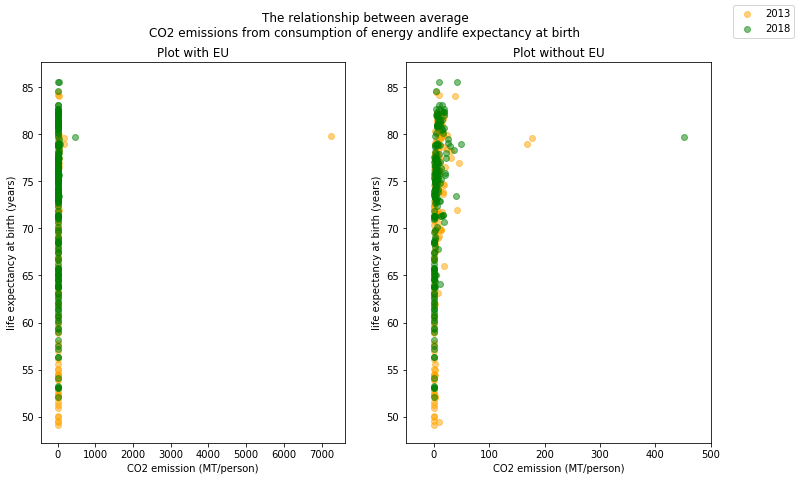

In [231]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
plt.suptitle('The relationship between average'\
             '\nCO2 emissions from consumption of energy and'\
             'life expectancy at birth')
for i in range(2):
    axs[i].scatter(x=df_co["average co2 emission"].loc[df_co['year']==2013], 
            y=df_co['life expectancy'].loc[df_co['year']==2013], 
            color='orange', alpha=0.5)
    axs[i].scatter(x=df_co["average co2 emission"].loc[df_co['year']==2018], 
            y=df_co['life expectancy'].loc[df_co['year']==2018], 
            color='green', alpha=0.5)
    axs[i].set_xlabel('CO2 emission (MT/person)')
    axs[i].set_ylabel('life expectancy at birth (years)')
axs[1].set_xlim(-50, 500)
# axs[1][0].set_xlim(-5, 50)
# axs[1][1].set_xlim(-1, 10)
axs[0].set_title('Plot with EU')
axs[1].set_title('Plot without EU')
fig.legend(labels=[2013,2018]);

There is one data point that is extremely distant from the rest and results in the very unexpected plot (plot 1). Look closely on the abnormal data point. 

In [232]:
display(Latex(df_co.loc[df_co['average co2 emission'] == df_co['average co2 emission'].max()].to_latex(index=False)))

<IPython.core.display.Latex object>

In [233]:
# summing up CO2 emission of all countries except EU
print('sum of CO2 emission of all countries except EU: ',
sum(df_co.loc[df_co['country'] != 'European Union']['carbon dioxide emission']))

sum of CO2 emission of all countries except EU:  74991386165.0


Notice that the sum of carbon dioxide emission of all the rest countries are about $7.5\times 10^{10}$ MT. I suspect that there is some error in the collected data and decided to remove this data point. 

In [234]:
df_co = df_co.loc[df_co['country'] != 'European Union']
display(Latex(df_co.loc[df_co['average co2 emission'] > 100].to_latex(index=False)))

<IPython.core.display.Latex object>

There are still a few (3) influential points that are so far from the majority of the data points. 

Because we want to investigate the relationship, and the abnormal points is so few and are not very significant. We will try to "room in" and see how the most data points distributed. 

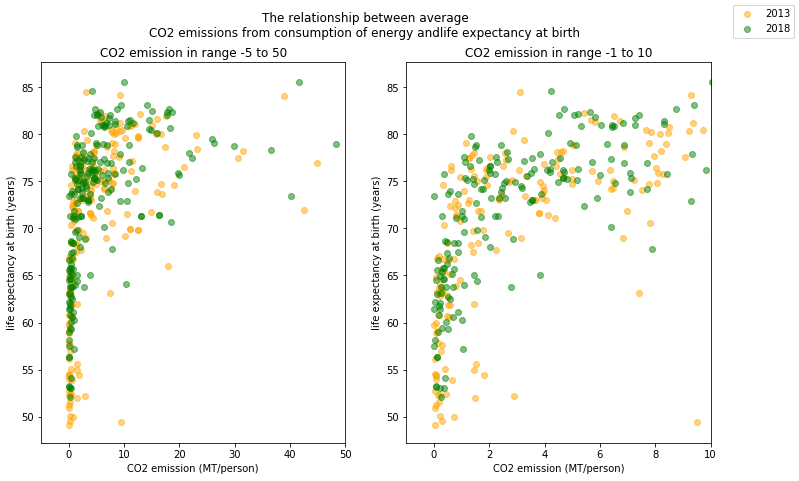

In [235]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
plt.suptitle('The relationship between average'\
             '\nCO2 emissions from consumption of energy and'\
             'life expectancy at birth')
for i in range(2):
    axs[i].scatter(x=df_co["average co2 emission"].loc[df_co['year']==2013], 
            y=df_co['life expectancy'].loc[df_co['year']==2013], 
            color='orange', alpha=0.5)
    axs[i].scatter(x=df_co["average co2 emission"].loc[df_co['year']==2018], 
            y=df_co['life expectancy'].loc[df_co['year']==2018], 
            color='green', alpha=0.5)
    axs[i].set_xlabel('CO2 emission (MT/person)')
    axs[i].set_ylabel('life expectancy at birth (years)')
axs[0].set_xlim(-5, 50)
axs[1].set_xlim(-1, 10)
axs[0].set_title('CO2 emission in range -5 to 50')
axs[1].set_title('CO2 emission in range -1 to 10')
fig.legend(labels=[2013,2018]);

Generally the increase in CO2 emission is associated with the increase in life expectancy at birth. However, the relationship between the two variables obviously does not follow a linear line. 

We can do a transformation on average CO2 emission and further investigate the relationship. 

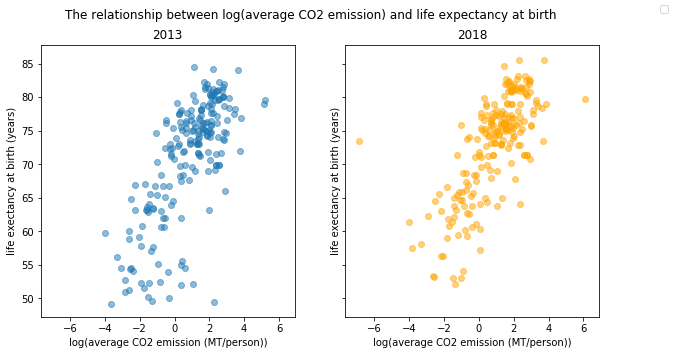

In [236]:
logx_13 = np.log(df_co.loc[df_co['year']==2013]['average co2 emission']);
logx_18 = np.log(df_co.loc[df_co['year']==2018]['average co2 emission']);
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True);
fig.suptitle('The relationship between log(average CO2 emission) and life expectancy at birth');
fig.legend([2013, 2018]);
axs[0].scatter(x=logx_13, y=df_co.loc[df_co['year']==2013]['life expectancy'], 
               alpha=0.5);
axs[0].set_xlabel('log(average CO2 emission (MT/person))');
axs[0].set_ylabel('life exectancy at birth (years)');
axs[0].set_title('2013');
axs[1].scatter(x=logx_18, y=df_co.loc[df_co['year']==2018]['life expectancy'], 
               alpha=0.5,  color='orange');
axs[1].set_xlabel('log(average CO2 emission (MT/person))');
axs[1].set_ylabel('life exectancy at birth (years)');
axs[1].set_title('2018');

I try a log transformation on average CO2 emission, the resulted scatter plot is above. It seems that after the transformation, there is a positive linear relationship between the natural log of average CO2 emission and life expectancy at birth. 

We can also see the plot with the fitted line below. 

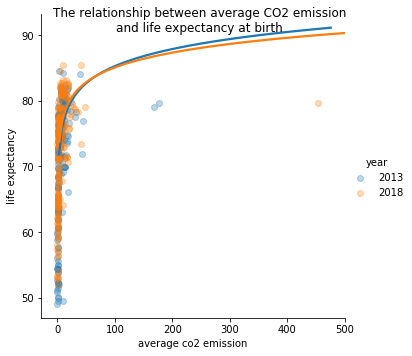

In [261]:
ax = sns.lmplot(x='average co2 emission', y='life expectancy', hue='year',
                data=df_co.dropna(), 
                logx=True, scatter_kws={'alpha':'0.3'}, 
                ci=None).fig
ax.suptitle("The relationship between average CO2 emission\nand life expectancy at birth");

Because the result above suggest that there is a linear positive relationship after a natural log transformation. I categorize the data points with average CO2 emission into 3 intervals $0 - e^{-2}, e^{-2}- e^2, e^2 - \infty$ where $e$ is the base of natural log, $e\approx 2.72$.

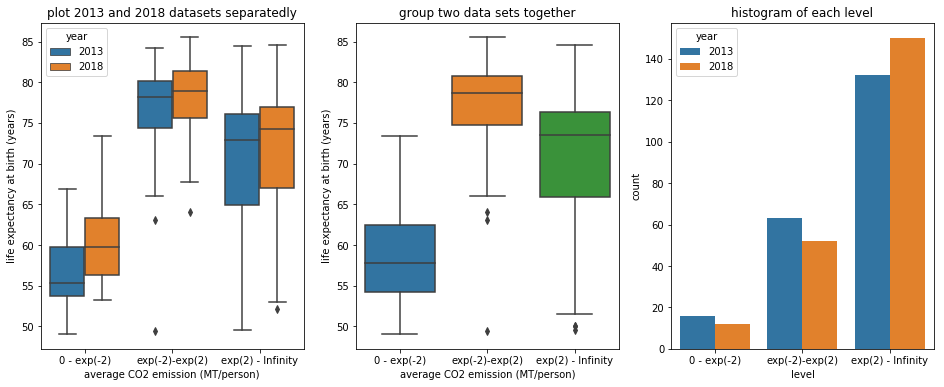

In [238]:
def co2cat(x):
    if x < math.exp(-2):
        return 0
    elif x > math.exp(2):
        return 2
    else: 
        return 3
    
df_co['level'] = df_co['average co2 emission'].apply(co2cat)

fig, axs = plt.subplots(1, 3, figsize = (16, 6))

sns.boxplot(x='level', y='life expectancy', hue='year', data=df_co, ax=axs[0])
axs[0].set_xticklabels(['0 - exp(-2)', 'exp(-2)-exp(2)','exp(2) - Infinity'])
axs[0].set_xlabel('average CO2 emission (MT/person)')
axs[0].set_ylabel('life expectancy at birth (years)')
axs[0].set_title('plot 2013 and 2018 datasets separatedly')

sns.boxplot(x='level', y='life expectancy', data=df_co, ax=axs[1])
axs[1].set_xticklabels(['0 - exp(-2)', 'exp(-2)-exp(2)','exp(2) - Infinity'])
axs[1].set_xlabel('average CO2 emission (MT/person)')
axs[1].set_ylabel('life expectancy at birth (years)')
axs[1].set_title('group two data sets together')

sns.countplot(x='level', hue='year', data=df_co, ax=axs[2])
axs[2].set_xticklabels(['0 - exp(-2)', 'exp(-2)-exp(2)','exp(2) - Infinity'])
axs[2].set_xlabel('level')
axs[2].set_ylabel('count')
axs[2].set_title('histogram of each level');

Unexpectedly, we observe that countries in interval $e^{2}- \infty$ has lower mean of life expectancy than those of in level $e^{-2}- e^2$, and the histogram shows that the sample size is large. The side by side box plots seems to suggest that the increase in average CO2 emission will not associate with the increase in health expenditure.
However, we also observe that there is a large difference between sample size in each level, we can try a different categorization. 

Try the new categorization by the data points with average CO2 emission in between $0 - 1, 1 -  e^2, e^2 - e^4, e^4 - \infty$. 

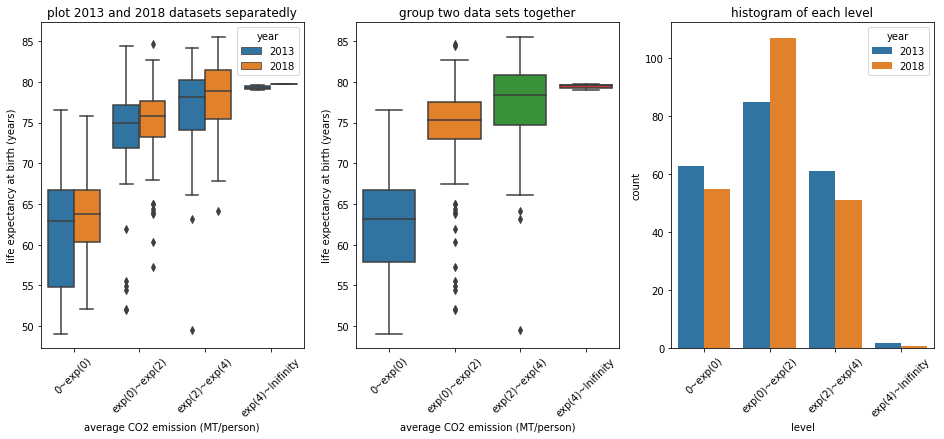

In [239]:
def co2cat(x):
    if x < 1:
        return 0
    elif x < math.exp(2):
        return 1
    elif x < math.exp(4):
        return 2
    else: 
        return 3
    
df_co['level'] = df_co['average co2 emission'].apply(co2cat)

fig, axs = plt.subplots(1, 3, figsize = (16, 6))

sns.boxplot(x='level', y='life expectancy', hue='year', data=df_co, ax=axs[0])
axs[0].set_xticklabels(['0~exp(0)', 'exp(0)~exp(2)','exp(2)~exp(4)', 'exp(4)~Inifinity'])
axs[0].set_xlabel('average CO2 emission (MT/person)')
axs[0].set_ylabel('life expectancy at birth (years)')
axs[0].set_title('plot 2013 and 2018 datasets separatedly')
axs[0].xaxis.set_tick_params(rotation=45)

sns.boxplot(x='level', y='life expectancy', data=df_co, ax=axs[1])
axs[1].set_xticklabels(['0~exp(0)', 'exp(0)~exp(2)','exp(2)~exp(4)', 'exp(4)~Inifinity'])
axs[1].set_xlabel('average CO2 emission (MT/person)')
axs[1].set_ylabel('life expectancy at birth (years)')
axs[1].set_title('group two data sets together')
axs[1].xaxis.set_tick_params(rotation=45)

sns.countplot(x='level', hue='year', data=df_co, ax=axs[2])
axs[2].set_xticklabels(['0~exp(0)', 'exp(0)~exp(2)','exp(2)~exp(4)', 'exp(4)~Inifinity'])
axs[2].set_xlabel('level')
axs[2].set_ylabel('count')
axs[2].set_title('histogram of each level')
axs[2].xaxis.set_tick_params(rotation=45)

In [260]:
display(Latex(df_co.loc[df_co['level'] == 3][['country','average co2 emission', 'life expectancy']].to_latex(index=False)))

<IPython.core.display.Latex object>

Notice that for the first three levels, the sample size are close enough, and since the sample size of the last level is so small, they are not overall significant. Also, the mean of average CO2 emission in each level is positively associated with life expectancy at birth. As previous investigation suggests, the relationship is not linear. 

### Conclusion 
For the investigations above, we have some evidence that there is an positive association between average carbon dioxide emission from consumption of energy and life expectancy at birth. This relationship is likely to be linear between life expectancy at birth and the natural log of average CO2 emission.

# Question 3

## 3.1 Is a countries' military expenditures associated with life expectancy at birth?

### Investigation
First, we use a scatter plot to visually examine all the data points.

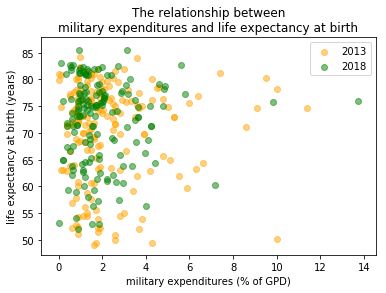

In [241]:
df_m_13 = df_13[['country', 'military expenditures', 'life expectancy']].dropna()
df_m_13['year'] = 2013
df_m_18 = df_18[['country', 'military expenditures', 'life expectancy']].dropna()
df_m_18['year'] = 2018
df_me = df_m_13.append(df_m_18)

fig = plt.figure()
plt.scatter(x=df_me['military expenditures'].loc[df_me['year']==2013], 
            y=df_me['life expectancy'].loc[df_me['year']==2013], 
            color='orange', alpha=0.5)
plt.scatter(x=df_me['military expenditures'].loc[df_me['year']==2018], 
            y=df_me['life expectancy'].loc[df_me['year']==2018], 
            color='green', alpha=0.5)
plt.title('The relationship between\nmilitary expenditures and ' + \
          'life expectancy at birth')
plt.xlabel('military expenditures (% of GPD)')
plt.ylabel('life expectancy at birth (years)')
plt.legend(labels=[2013,2018]);

Looking at the scatter plot, we do not see any significant relationship between the two variables. Using Pearson correlation coefficient to evaluate the correlation between the two variables. 

In [242]:
print('The Pearson correlation coefficient is: ',
    np.corrcoef(df_me['military expenditures'], df_me['life expectancy'])[0][1])

The Pearson correlation coefficient is:  0.016556740216071866


The Pearson correlation coefficient is very close to 0, therefore we have evidence that there is no evidence that life expectancy at birth is associated with military expenditures. 

I divide the data points into two levels, the countries with military expenditures below 2% are in 'low' and the rest are 'high'. By this categorization, I expect that the two groups have a relatively equal size. Then, I further investigate the mean difference of life expectancy of the two groups. 

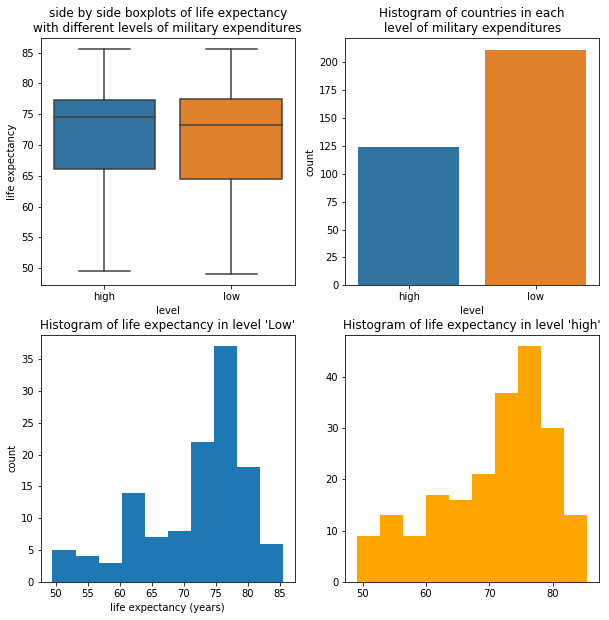

In [243]:
df_me['level'] = df_me['military expenditures'].apply(lambda x: 'low' if x < 2 else 'high')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.boxplot(x='level', y='life expectancy', data=df_me, ax=axs[0][0])
sns.countplot(x='level', data=df_me, ax=axs[0][1])
axs[0][0].set_title("side by side boxplots of life expectancy\nwith different levels of military expenditures")
axs[0][1].set_title('Histogram of countries in each\nlevel of military expenditures')
axs[1][0].hist(x=df_me.loc[df_me['level']=='high']['life expectancy'])
axs[1][0].set_title("Histogram of life expectancy in level 'Low'")
axs[1][0].set_xlabel('life expectancy (years)')
axs[1][0].set_ylabel('count')
axs[1][1].hist(x=df_me.loc[df_me['level']=='low']['life expectancy'], color='orange')
axs[1][1].set_title("Histogram of life expectancy in level 'high'")
axs[1][0].set_xlabel('life expectancy (years)')
axs[1][0].set_ylabel('count');

From the side by side box plot, the mean of life expectancy of two groups are very close. Also, from the pair of histograms, we notice that the distribution of two groups are very similar. 

We will further run a two sample t-test to investigate whether the means are equal. 

In [244]:
stat, p = sp.stats.ttest_ind(df_me.loc[df_me['level']=='low']['life expectancy'],
                   df_me.loc[df_me['level']=='high']['life expectancy'])

print('The result of two sample t-test: ', 
      '\nTest statistic: ',stat,
      '\np-value: ', p)

The result of two sample t-test:  
Test statistic:  -0.958064378732529 
p-value:  0.3387253529228582


**Two sample t-test**<br>
Null hypothesis: $H_0: \mu_a = \mu_b$ <br>
Alternative hypothesis: $H_a: \mu_a \neq \mu_b$ <br>
Where $\mu_x$ is the mean life expectancy of countries in 'low' group, $\mu_y$ is the mean life expectancy of countries in 'high' group. <br>
Test statistic: 0.96 <br>
p-value: 0.34

Since the p-value is large, we cannot reject the null hypothesis.


### Conclusion
By the investigation above, we have some evidence that a country's military expenditures is not associated with life expectancy at birth. 

## 3.2 Is a countries' birth rate associated with life expectancy at birth?
### Investigation
First, we use a scatter plot to visually examine all the data points.

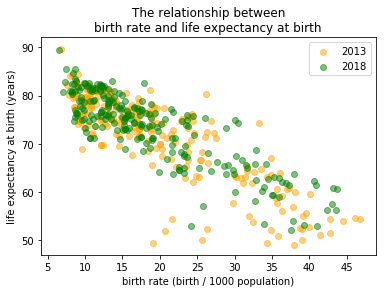

In [245]:
df_m_13 = df_13[['country', 'birth rate', 'life expectancy']].dropna()
df_m_13['year'] = 2013
df_m_18 = df_18[['country', 'birth rate', 'life expectancy']].dropna()
df_m_18['year'] = 2018
df_br = df_m_13.append(df_m_18)

fig = plt.figure()
plt.scatter(x=df_br['birth rate'].loc[df_br['year']==2013], 
            y=df_br['life expectancy'].loc[df_br['year']==2013], 
            color='orange', alpha=0.5)
plt.scatter(x=df_br['birth rate'].loc[df_br['year']==2018], 
            y=df_br['life expectancy'].loc[df_br['year']==2018], 
            color='green', alpha=0.5)
plt.title('The relationship between\nbirth rate and ' + \
          'life expectancy at birth')
plt.xlabel('birth rate (birth / 1000 population)')
plt.ylabel('life expectancy at birth (years)')
plt.legend(labels=[2013,2018]);

The scatter plot shows some evidence that there is a negative linear relationship between birth rate and life expectancy. We can further do a linear regression.

In [246]:
s13, i13, r13, p13, std13 = sp.stats.linregress(df_br.loc[df_br['year']==2013]['birth rate'], 
                    df_br.loc[df_br['year']==2013]['life expectancy'])
s18, i18, r18, p18, std18 = sp.stats.linregress(df_br.loc[df_br['year']==2018]['birth rate'], 
                    df_br.loc[df_br['year']==2018]['life expectancy'])

print("Linear regression for Year 2013: ",
      '\nslope: ', s13,
      '\nintercept: ', i13, 
      '\nrvalue: ', r13, 
      '\npvalue: ', p13)
print()
print("Linear regression for Year 2018: ",
      '\nslope: ', s18,
      '\nintercept: ', i18, 
      '\nrvalue: ', r18, 
      '\npvalue: ', p18)

Linear regression for Year 2013:  
slope:  -0.7724902036388788 
intercept:  86.78089698508221 
rvalue:  -0.8411658277065387 
pvalue:  5.3560305325866175e-62

Linear regression for Year 2018:  
slope:  -0.7065512392511272 
intercept:  86.51488234174981 
rvalue:  -0.8625574819675528 
pvalue:  8.280249892253233e-69


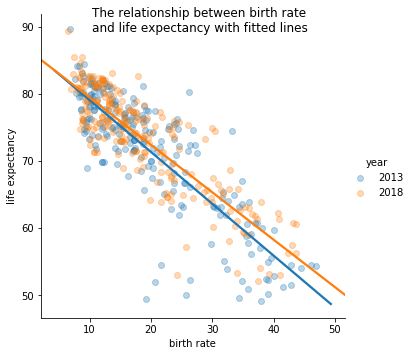

In [247]:
ax = sns.lmplot(x='birth rate', y='life expectancy', hue='year',
           data=df_br.dropna(), scatter_kws={'alpha':'0.3'}, ci=None).fig
ax.suptitle('The relationship between birth rate\nand life expectancy with fitted lines');

The fitted line has a negative slope. The hypothesis test  gives p-value very close to 0 ($5.35\times 10^{-62}, 8.28\times 10^{-69}$), and the correlation coefficient are large ($0.86, 0.86$). Therefore, there is strong evidence that birth rate and life expectancy at birth are negatively associated. 

Then, I will categorize data points using birth rate into 5 intervals: $0-10, 10-20, 20-30, 30-40, 40-50$ because I suspect that the relationship is linear. This categorization is expected to give a relatively equal size for each level and a constant decrease in mean. Then, I do the side by side box-plots based on the categorization.

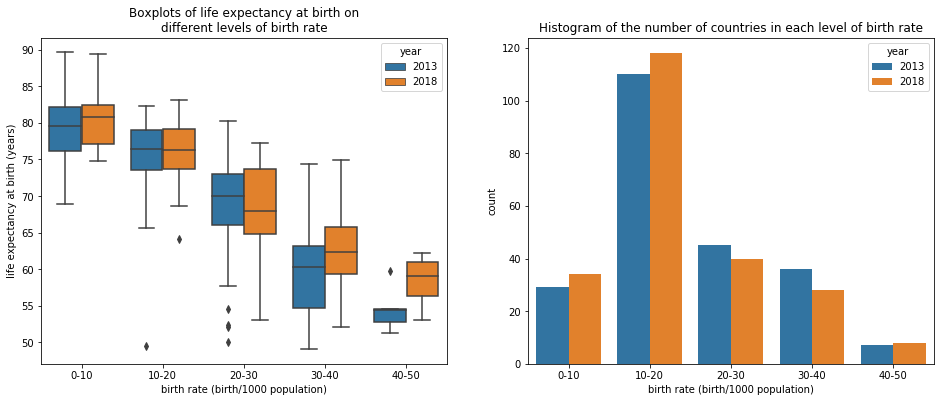

In [248]:
df_br['level'] = df_br['birth rate'].apply(lambda x: x//10)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='level', y='life expectancy', hue='year', data=df_br, ax=axs[0])
axs[0].set_xticklabels(['0-10', '10-20','20-30','30-40','40-50'])
axs[0].set_xlabel('birth rate (birth/1000 population)')
axs[0].set_ylabel('life expectancy at birth (years)')
axs[0].set_title('Boxplots of life expectancy at birth on\ndifferent levels of birth rate')

sns.countplot(x='level', hue='year',data=df_br)
axs[1].set_xticklabels(['0-10', '10-20','20-30','30-40','40-50'])
axs[1].set_xlabel('birth rate (birth/1000 population)')
axs[1].set_title('Histogram of the number of countries in each level of birth rate');

The side by side box plot shows that the relationship is negative, and the relationship is likely to be linear. 

### Conclusion
By the investigations, we have strong evidence that there is a negative linear relationship between birth rate and life expectancy at birth. 

# Conclusion and Discussion
In this report, I investigate the questions and conclude that: 

1. Has global life expectancy at birth changed between 2013 to 2018? Which continents and countries have experienced the least and greatest changes? 

Global life expectancy at birth improved between 2013 and 2018. The change had more influence on the countries of low life expectancy, and had little influence on the countries of high life expectancy. More specifically, the mean life expectancy had only a little improvement, but the lower quartile improved significantly.

Among the continents, Africa experienced the greatest changes, and North America experienced the least changes.

Among all countries, Gaza Strip experienced the least changes, and Gabon experienced the most changes. 

2. Are a countries' health expenditures and carbon dioxide emissions from consumption of energy associated with life expectancy at birth?

A countries' health expenditures and carbon dioxide emissions from consumption of energy are likely to be associated with life expectancy at birth. This association is likely to be positive.

For the association between health expenditures and life expectancy at birth, the relationship is likely to be positive linear, the association is stronger for countries with less than $15\%$ health expenditures. 

For the association between carbon dioxide emission from consumption of energy, notice that we measure average carbon dioxide emission per person, and the relationship is likely to be positive and linear after a log transformation to average carbon dioxide emission. 

3. Are a countries' military expenditures and birth rate associated with life expectancy at birth?

There is no evidence suggesting that a countries' military expenditures is associated with life expectancy at birth, while there is strong evidence suggesting that a countries' birth rate is associated with life expectancy at birth. The relationship between life expectancy at birth and birth rate is likely to be negative linear. 

For the limitations and further improvements: 
 - Although the collected datasets are assumed to be data from 2013 and 2018, the date of information shows that the assumption is not true. The problem is significant when I measure the average CO2 emission for Question 2.2, I suspect that the different date of information for CO2 emission and population may result in errors.
 - Further research should be done on the wars and/or natural disasters happened from 2013 to 2018. These incidents will have great influence on individual countries' life expectancy at birth. We may consider to remove them since they are not very significant in investigating relationships with other factors. 